In [1]:
import os, argparse, json, random, copy, math
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter, defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available. Using CPU.")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
os.makedirs("results", exist_ok=True)

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
# Preprocessing function
def preprocess_df(df):
    df.columns = [c.strip() for c in df.columns]
    required = ["sport","dsport","proto","service","dur","sbytes","dbytes","Spkts","Dpkts",
                "Sintpkt","ct_srv_src","ct_srv_dst","ct_dst_ltm","hour_of_day","attack_cat","Label"]
    for c in required:
        if c not in df.columns:
            raise ValueError(f"Missing column {c}")

    df["attack_cat"] = df["attack_cat"].replace("", np.nan).fillna("Normal")
    df["Label"] = pd.to_numeric(df["Label"], errors="coerce").fillna(0).astype(int)
    df["hour_of_day"] = pd.to_numeric(df["hour_of_day"], errors="coerce").fillna(0).astype(int)
    df["proto_enc"] = LabelEncoder().fit_transform(df["proto"].astype(str))
    df["service_enc"] = LabelEncoder().fit_transform(df["service"].astype(str))

    numeric_cols = ["sport","dsport","dur","sbytes","dbytes","Spkts","Dpkts","Sintpkt",
                    "ct_srv_src","ct_srv_dst","ct_dst_ltm","hour_of_day"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    le_attack = LabelEncoder()
    df["attack_cat"] = df["attack_cat"].astype(str)
    df["attack_label"] = le_attack.fit_transform(df["attack_cat"])
    return df, le_attack

In [ ]:
# Graph Creation 

def build_graphs(df, max_nodes=120):
    graphs = []
    for (hour, service), grp in df.groupby(["hour_of_day", "service"]):
        grp = grp.reset_index(drop=True)

        for i in range(0, len(grp), max_nodes):
            sub = grp.iloc[i:i+max_nodes]
            G = nx.Graph()

            # Build graph nodes
            for idx, row in sub.iterrows():
                feats = np.concatenate([
                    row[["sport","dsport","dur","sbytes","dbytes","Spkts","Dpkts","Sintpkt",
                         "ct_srv_src","ct_srv_dst","ct_dst_ltm","hour_of_day"]].to_numpy(),
                    [row["proto_enc"], row["service_enc"]]
                ]).astype(np.float32)
                G.add_node(idx, x=feats, y=row["attack_label"], label=row["Label"], attack=row["attack_cat"])

            # Add edges (simple pairwise rule)
            nodes = list(G.nodes)
            for a in range(len(nodes)):
                for b in range(a + 1, len(nodes)):
                    ra, rb = G.nodes[nodes[a]], G.nodes[nodes[b]]
                    if ra['x'][-2] == rb['x'][-2] or ra['x'][-1] == rb['x'][-1]:
                        G.add_edge(nodes[a], nodes[b])
                    elif abs(ra['x'][0] - rb['x'][0]) < 1e-3 or abs(ra['x'][1] - rb['x'][1]) < 1e-3:
                        G.add_edge(nodes[a], nodes[b])

            # Manual conversion
            x = np.array([G.nodes[n]['x'] for n in G.nodes], dtype=np.float32)
            x = torch.from_numpy(x)

            # Build edge_index tensor 
            edges = np.array(list(G.edges), dtype=np.int64)
            if edges.size == 0:
                edge_index = torch.empty((2, 0), dtype=torch.long)
            else:
                max_index = x.size(0)
                edges = edges[(edges[:, 0] < max_index) & (edges[:, 1] < max_index)]
                edge_index = torch.from_numpy(edges.T)

            # Majority class label for this subgraph
            label = Counter([G.nodes[n]['y'] for n in G.nodes]).most_common(1)[0][0]
            y = torch.tensor([label], dtype=torch.long)

            # Binary flag
            binary = torch.tensor(
                [1 if any(G.nodes[n]['label'] for n in G.nodes) else 0],
                dtype=torch.long
            )

            batch = torch.zeros(x.size(0), dtype=torch.long)

            # Create PyG Data object
            data = Data(x=x, edge_index=edge_index, y=y, binary=binary, batch=batch)

            if edge_index.numel() > 0 and edge_index.max() >= x.size(0):
                print(f"Invalid edge index detected! hour={hour}, service={service}, nodes={x.size(0)}")

            graphs.append(data)

    return graphs


In [4]:
# Preprocessing function
def preprocess_df(df):
    df.columns = [c.strip() for c in df.columns]
    required = ["sport","dsport","proto","service","dur","sbytes","dbytes","Spkts","Dpkts",
                "Sintpkt","ct_srv_src","ct_srv_dst","ct_dst_ltm","hour_of_day","attack_cat","Label"]
    for c in required:
        if c not in df.columns:
            raise ValueError(f"Missing column {c}")

    df["attack_cat"] = df["attack_cat"].replace("", np.nan).fillna("Normal")
    df["Label"] = pd.to_numeric(df["Label"], errors="coerce").fillna(0).astype(int)
    df["hour_of_day"] = pd.to_numeric(df["hour_of_day"], errors="coerce").fillna(0).astype(int)
    df["proto_enc"] = LabelEncoder().fit_transform(df["proto"].astype(str))
    df["service_enc"] = LabelEncoder().fit_transform(df["service"].astype(str))

    numeric_cols = ["sport","dsport","dur","sbytes","dbytes","Spkts","Dpkts","Sintpkt",
                    "ct_srv_src","ct_srv_dst","ct_dst_ltm","hour_of_day"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    le_attack = LabelEncoder()
    df["attack_cat"] = df["attack_cat"].astype(str)
    df["attack_label"] = le_attack.fit_transform(df["attack_cat"])
    return df, le_attack

In [5]:
# GraphSAGE Model - prediction of attack type
class GraphSAGEClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(self.dropout(x))

# Training Utils 
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            out = model(batch)
            prob = torch.softmax(out, dim=1)
            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(prob.argmax(dim=1).cpu().numpy())
            y_prob.extend(prob.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
    try:
        auc = roc_auc_score(y_true, np.array(y_prob), multi_class="ovr")
    except Exception:
        auc = 0.0
    return acc, prec, rec, f1, auc, (y_true, y_pred)

In [6]:
def train_local(graphs, global_state, num_classes, config, name):
    shuffled = random.sample(graphs, len(graphs))
    split1, split2 = int(0.7 * len(shuffled)), int(0.85 * len(shuffled))
    train, val, test = shuffled[:split1], shuffled[split1:split2], shuffled[split2:]
    in_dim = graphs[0].x.shape[1]
    model = GraphSAGEClassifier(in_dim, config["hidden_dim"], num_classes).to(DEVICE)
    if global_state: model.load_state_dict(global_state, strict=False)
        
    # Compute class weights safely (avoid division by zero)
    labels = [g.y.item() for g in graphs]
    class_counts = Counter(labels)
    weights = []
    epsilon = 1e-6  # small constant to prevent division by zero
    for i in range(num_classes):
        count = class_counts.get(i, 0)
        weights.append(1.0 / (count + epsilon))
    weights = torch.tensor(weights, dtype=torch.float32).to(DEVICE)

    criterion = nn.CrossEntropyLoss(weight=weights)
    optimzr = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["wd"])
    train_loader, val_loader = DataLoader(train, batch_size=8, shuffle=True), DataLoader(val, batch_size=8)
    best, wait, patience = None, 0, 4
    for ep in range(config["epochs"]):
        model.train()
        losses = []
        for b in train_loader:
            b = b.to(DEVICE)
            optimzr.zero_grad()
            loss = criterion(model(b), b.y)
            loss.backward(); optimzr.step(); losses.append(loss.item())
        val_acc, _, _, val_f1, _, _ = evaluate(model, val_loader)
        print(f"[{name}] Epoch {ep+1} loss={np.mean(losses):.4f} val_acc={val_acc:.3f} f1={val_f1:.3f}")
        if val_acc > (best[0] if best else 0): best, wait = (val_acc, copy.deepcopy(model.state_dict())), 0
        else: wait += 1
        if wait>=patience: print(f"[{name}] Early stop"); break
    model.load_state_dict(best[1]); test_loader=DataLoader(test,8)
    acc,prec,rec,f1,auc,(yt,yp)=evaluate(model,test_loader)
    print(f"[{name}] Test: acc={acc:.3f} f1={f1:.3f} auc={auc:.3f}")
    return copy.deepcopy(model.state_dict()), {"acc":acc,"prec":prec,"rec":rec,"f1":f1,"auc":auc,"yt":yt,"yp":yp}


In [ ]:
# Federated Setup
def create_clients(graphs, num_clients=3):
    feats = np.array([[np.mean(g.x[:, -2].numpy()), np.mean(g.x[:, -1].numpy())] for g in graphs])
    kmeans = KMeans(n_clusters=num_clients, random_state=SEED).fit(feats)
    clients = {i: [] for i in range(num_clients)}
    for i, lbl in enumerate(kmeans.labels_):
        clients[lbl].append(graphs[i])
    return clients

In [8]:
def average_states(states):
    avg = copy.deepcopy(states[0])
    for k in avg.keys(): avg[k] = sum([s[k] for s in states]) / len(states)
    return avg

In [ ]:
def test_model(attack_enc=None, model_path="results/global_model.pt"):
    print("\nTesting saved model...")
    try:
        model = torch.load(model_path, map_location=DEVICE)
    except FileNotFoundError:
        print("Model file not found! Please train first.")
        return
    
    in_dim = 14  # total feature count used during training (12 base + 2 encodings)
    num_classes = len(attack_enc.classes_) if attack_enc else 10
    net = GraphSAGEClassifier(in_dim, 64, num_classes).to(DEVICE)

    # Model loading
    if isinstance(model, dict):
        missing, unexpected = net.load_state_dict(model, strict=False)
        if missing or unexpected:
            print(f"⚠️ Warning: Partial model load. Missing keys: {missing}, Unexpected: {unexpected}")
    else:
        print("⚠️ Loaded object is not a state_dict — skipping load_state_dict.")

    net.eval()

    # Synthetic graph for demo prediction
    print("\nDemo Prediction on synthetic input:")
    dummy_x = torch.randn(10, in_dim).to(DEVICE)
    dummy_edge_index = torch.randint(0, 10, (2, 20)).to(DEVICE)
    dummy_batch = torch.zeros(10, dtype=torch.long).to(DEVICE)
    data = Data(x=dummy_x, edge_index=dummy_edge_index, batch=dummy_batch)

    out = torch.softmax(net(data), dim=1).detach().cpu().numpy()[0]
    pred = int(np.argmax(out))

    # Decode prediction
    if attack_enc:
        attack_type = attack_enc.inverse_transform([pred])[0]
    else:
        attack_type = f"Type{pred}"

    malicious = attack_type != "Normal"

    print(f"🔹 Predicted attack type: {attack_type}")
    print(f"🔸 Malicious: {'Yes' if malicious else 'No'}")

    # Recommended countermeasures
    mitigation = {
        "Exploits":["Patch vulnerable software","Enable IPS","Run vuln scans","Harden systems"],
        "Reconnaissance":["Deploy IDS","Block ICMP sweeps","Rate-limit unknown IPs"],
        "Fuzzers":["Input validation","Segment networks","Limit error verbosity"],
        "DoS":["Rate limiting","Use CDN/WAF","Monitor anomalies"],
        "Generic":["Update AV","Use sandboxing","Inspect traffic anomalies"],
        "Analysis":["Secure logging","Restrict admin rights","Monitor host activity"],
        "Backdoor":["Re-image systems","Rotate credentials","Use MFA"],
        "Shellcode":["Patch memory vulns","Enable DEP/ASLR","Deploy EDR"],
        "Worms":["Isolate networks","Patch systems","Disable SMB/RPC"],
        "Normal":["No attack detected","Maintain routine monitoring"]
    }

    print("\nRecommended Countermeasures:")
    for step in mitigation.get(attack_type, ["No data."]):
        print(" •", step)


In [10]:
def clean_json(obj):
    if isinstance(obj, dict):
        return {k: clean_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [clean_json(i) for i in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    else:
        return obj

In [ ]:
def main(args):
    """
    Runs the full federated training pipeline in Jupyter Notebook mode.
    Saves global model and metrics in 'results/' folder.
    """

    print("\nLoading dataset...")
    df = pd.read_csv(args.csv, low_memory=False)
    df, attack_enc = preprocess_df(df)

    print("Building graphs...")
    graphs = build_graphs(df)
    clients = create_clients(graphs, args.num_clients)
    print(f"Built {len(graphs)} graphs across {args.num_clients} clients")

    config = {
        "epochs": args.epochs_local,
        "lr": 1e-3,
        "wd": 1e-4,
        "hidden_dim": args.hidden_dim
    }

    global_state = None
    allres = {}

    for r in range(args.rounds):
        print(f"\n=== Round {r+1}/{args.rounds} ===")
        states, roundm = [], {}

        for i in range(args.num_clients):
            print(f"\n🔹 Training Client {i+1}")
            state, met = train_local(
                clients[i],
                global_state,
                len(attack_enc.classes_),
                config,
                f"Client{i+1}"
            )
            states.append(state)
            roundm[f"Client{i+1}"] = met

        global_state = average_states(states)
        torch.save(global_state, "results/global_model.pt")
        allres[f"Round{r+1}"] = roundm

        # Confusion Matrix Visualization
        all_y, all_p = [], []
        for c in roundm.values():
            all_y.extend(c["yt"])
            all_p.extend(c["yp"])

        cm = confusion_matrix(all_y, all_p)
        unique_classes = sorted(set(all_y) | set(all_p))
        display_labels = [attack_enc.classes_[i] for i in unique_classes]

        disp = ConfusionMatrixDisplay(cm, display_labels=display_labels)
        disp.plot(xticks_rotation=90)
        plt.title(f"Confusion Matrix - Round {r+1}")
        plt.tight_layout()
        plt.savefig(f"results/confmat_round{r+1}.png")
        plt.show()

    with open("results/metrics.json", "w") as f:
        json.dump(clean_json(allres), f, indent=2)

    print("\nTraining complete. Model saved to results/global_model.pt")
    print("Metrics saved to results/metrics.json")

    # Optionally run test_model right after training
    test_model(attack_enc)



📥 Loading dataset...
📊 Building graphs...
✅ Built 2528 graphs across 5 clients

🚀 === Round 1/3 ===

🔹 Training Client 1
[Client1] Epoch 1 loss=0.1127 val_acc=1.000 f1=1.000
[Client1] Epoch 2 loss=0.0000 val_acc=1.000 f1=1.000
[Client1] Epoch 3 loss=0.0000 val_acc=1.000 f1=1.000
[Client1] Epoch 4 loss=0.0000 val_acc=1.000 f1=1.000
[Client1] Epoch 5 loss=0.0000 val_acc=1.000 f1=1.000
[Client1] Early stop
[Client1] Test: acc=0.996 f1=0.993 auc=0.000

🔹 Training Client 2
[Client2] Epoch 1 loss=3.7245 val_acc=0.952 f1=0.929
[Client2] Epoch 2 loss=1.4044 val_acc=0.857 f1=0.879
[Client2] Epoch 3 loss=0.5202 val_acc=0.857 f1=0.879
[Client2] Epoch 4 loss=0.7862 val_acc=0.857 f1=0.879
[Client2] Epoch 5 loss=0.9245 val_acc=0.952 f1=0.952
[Client2] Early stop
[Client2] Test: acc=0.955 f1=0.932 auc=0.000

🔹 Training Client 3
[Client3] Epoch 1 loss=5.0906 val_acc=0.667 f1=0.533
[Client3] Epoch 2 loss=3.7939 val_acc=0.667 f1=0.533
[Client3] Epoch 3 loss=3.5364 val_acc=0.000 f1=0.000
[Client3] Epoch

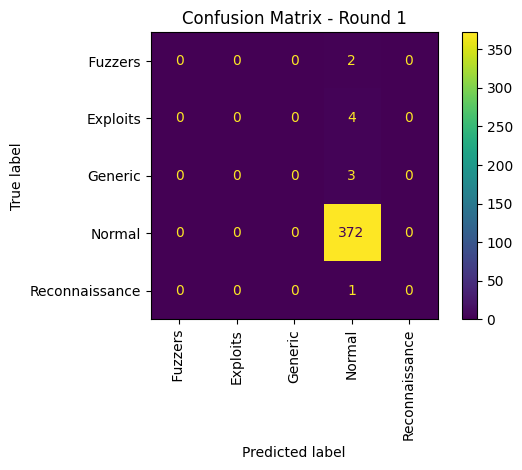


🚀 === Round 2/3 ===

🔹 Training Client 1
[Client1] Epoch 1 loss=0.0516 val_acc=1.000 f1=1.000
[Client1] Epoch 2 loss=0.1197 val_acc=1.000 f1=1.000
[Client1] Epoch 3 loss=0.1360 val_acc=1.000 f1=1.000
[Client1] Epoch 4 loss=0.1194 val_acc=1.000 f1=1.000
[Client1] Epoch 5 loss=0.1284 val_acc=1.000 f1=1.000
[Client1] Early stop
[Client1] Test: acc=1.000 f1=1.000 auc=0.000

🔹 Training Client 2
[Client2] Epoch 1 loss=1.4973 val_acc=0.905 f1=0.860
[Client2] Epoch 2 loss=1.0151 val_acc=0.905 f1=0.860
[Client2] Epoch 3 loss=0.5897 val_acc=0.905 f1=0.860
[Client2] Epoch 4 loss=0.4512 val_acc=0.905 f1=0.882
[Client2] Epoch 5 loss=0.3346 val_acc=0.905 f1=0.882
[Client2] Early stop
[Client2] Test: acc=1.000 f1=1.000 auc=0.000

🔹 Training Client 3
[Client3] Epoch 1 loss=1.9044 val_acc=1.000 f1=1.000
[Client3] Epoch 2 loss=1.5361 val_acc=1.000 f1=1.000
[Client3] Epoch 3 loss=1.3540 val_acc=1.000 f1=1.000
[Client3] Epoch 4 loss=1.1403 val_acc=1.000 f1=1.000
[Client3] Epoch 5 loss=1.0227 val_acc=1.00

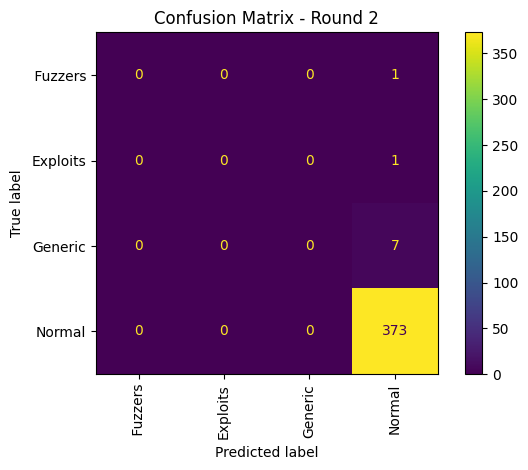


🚀 === Round 3/3 ===

🔹 Training Client 1
[Client1] Epoch 1 loss=0.1369 val_acc=1.000 f1=1.000
[Client1] Epoch 2 loss=0.1201 val_acc=1.000 f1=1.000
[Client1] Epoch 3 loss=0.1477 val_acc=1.000 f1=1.000
[Client1] Epoch 4 loss=0.0976 val_acc=1.000 f1=1.000
[Client1] Epoch 5 loss=0.1230 val_acc=1.000 f1=1.000
[Client1] Early stop
[Client1] Test: acc=1.000 f1=1.000 auc=0.000

🔹 Training Client 2
[Client2] Epoch 1 loss=2.4223 val_acc=0.905 f1=0.860
[Client2] Epoch 2 loss=1.4456 val_acc=0.905 f1=0.860
[Client2] Epoch 3 loss=0.7501 val_acc=0.905 f1=0.860
[Client2] Epoch 4 loss=0.5760 val_acc=0.905 f1=0.860
[Client2] Epoch 5 loss=0.3416 val_acc=0.905 f1=0.860
[Client2] Early stop
[Client2] Test: acc=1.000 f1=1.000 auc=0.000

🔹 Training Client 3
[Client3] Epoch 1 loss=1.5332 val_acc=0.333 f1=0.167
[Client3] Epoch 2 loss=1.1376 val_acc=0.333 f1=0.167
[Client3] Epoch 3 loss=1.1392 val_acc=0.333 f1=0.167
[Client3] Epoch 4 loss=0.9941 val_acc=0.333 f1=0.167
[Client3] Epoch 5 loss=0.8705 val_acc=0.33

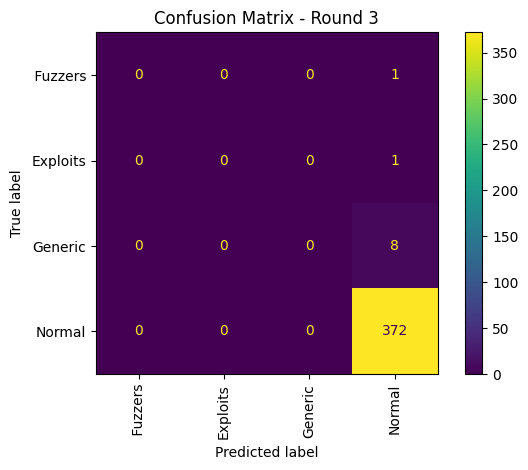


✅ Training complete. Model saved to results/global_model.pt
📈 Metrics saved to results/metrics.json

🧠 Testing saved model...


RuntimeError: Error(s) in loading state_dict for GraphSAGEClassifier:
	size mismatch for conv1.lin_l.weight: copying a param with shape torch.Size([64, 14]) from checkpoint, the shape in current model is torch.Size([64, 16]).
	size mismatch for conv1.lin_r.weight: copying a param with shape torch.Size([64, 14]) from checkpoint, the shape in current model is torch.Size([64, 16]).

In [ ]:
# Notebook Parameters
class Args:
    csv = "data/UNSW_NB15_reduced_features.csv"
    num_clients = 5
    rounds = 3
    epochs_local = 8
    batch_size = 8
    hidden_dim = 64
    test_only = False
    model_path = "results/global_model.pt"

args = Args()

# sRun Training
main(args)

In [1]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import torch
from torch_geometric.data import Data


# Load the same CSV you trained on
df = pd.read_csv("data/UNSW_NB15_reduced_features.csv", low_memory=False)

# Rebuild the label encoder exactly as training did
le_attack = LabelEncoder()
df["attack_cat"] = df["attack_cat"].fillna("Normal").astype(str)
le_attack.fit(df["attack_cat"])

attack_enc = le_attack  # assign to same name used in test_model()

# Now safely run
test_model(attack_enc)


ModuleNotFoundError: No module named 'torch_geometric'

In [3]:
test_model(attack_enc)

NameError: name 'attack_enc' is not defined

In [12]:
!pip install torch